In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adni-extracted-axial/Axial/CI/CI128_S_1148a099.png
/kaggle/input/adni-extracted-axial/Axial/AD/AD136_S_0426a120.png
/kaggle/input/adni-extracted-axial/Axial/CN/CN018_S_0369a121.png


In [61]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-rebyd25l
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-rebyd25l
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 2ec2f1aa73e3976553b1ddcb4245a42052a59138
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [62]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import torch
from tqdm.auto import tqdm
import numpy as np
import os
import sys
import cv2
import glob
import math
import time
import timm
import torch
import random
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from torch import nn, optim
from torchinfo import summary
from tabulate import tabulate
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.image as mpimg
from torchvision import transforms
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import LambdaLR
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [63]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [64]:
ds = ImageFolder('/kaggle/input/adni-extracted-axial/Axial', transform = transform)

In [65]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, ConcatDataset

labels = [label for _, label in ds]

sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices_1, test_indices = next(sss_train_test.split(torch.zeros(len(labels)), labels))

# Create Subset objects for train and test sets
train_data_1 = Subset(ds, train_indices_1)
test_data = Subset(ds, test_indices)

# Extract labels from the train subset for train-validation split
train_labels_1 = [label for _, label in train_data_1]

# Perform stratified shuffle split for train and validation
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(sss_train_val.split(torch.zeros(len(train_labels_1)), train_labels_1))

# Create Subset objects for train and validation sets
train_data = Subset(train_data_1, train_indices)
val_data = Subset(train_data_1, val_indices)

In [66]:
from collections import defaultdict

# Define a dictionary to store the counts of images in each class
train_class_counts = defaultdict(int)
val_class_counts = defaultdict(int)
test_class_counts = defaultdict(int)

# Iterate over train_data and count the occurrences of each class label
for _, label in train_data:
    train_class_counts[label] += 1

# Iterate over val_data and count the occurrences of each class label
for _, label in val_data:
    val_class_counts[label] += 1

# Iterate over test_data and count the occurrences of each class label
for _, label in test_data:
    test_class_counts[label] += 1

# Print the counts for train, val, and test datasets
print("Train Dataset Class Counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nValidation Dataset Class Counts:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nTest Dataset Class Counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} images")


Train Dataset Class Counts:
Class 1: 1657 images
Class 2: 922 images
Class 0: 719 images

Validation Dataset Class Counts:
Class 1: 415 images
Class 2: 230 images
Class 0: 180 images

Test Dataset Class Counts:
Class 2: 288 images
Class 1: 518 images
Class 0: 225 images


In [67]:
device = torch.device('cuda')


In [68]:
device

device(type='cuda')

In [69]:
num_classes = 3

# Create the model
model = timm.create_model('pit_ti_224', pretrained=True)

# Modify the model's output head
model.head = torch.nn.Linear(model.head.in_features, num_classes)

# Move the model to the specified device
model.to(device)

# Print the model summary
summary(model, (3, 224, 224))  #

Layer (type:depth-idx)                             Output Shape              Param #
PoolingVisionTransformer                           [1, 3]                    46,720
├─ConvEmbedding: 1-1                               [64, 27, 27]              --
│    └─Conv2d: 2-1                                 [64, 27, 27]              49,216
├─Dropout: 1-2                                     [1, 64, 27, 27]           --
├─SequentialTuple: 1-3                             [1, 256, 7, 7]            --
│    └─Transformer: 2-2                            [1, 64, 27, 27]           --
│    │    └─Identity: 3-1                          [1, 730, 64]              --
│    │    └─Sequential: 3-2                        [1, 730, 64]              99,968
│    └─Transformer: 2-3                            [1, 128, 14, 14]          --
│    │    └─Pooling: 3-3                           [1, 128, 14, 14]          9,600
│    │    └─Identity: 3-4                          [1, 197, 128]             --
│    │    └─Sequenti

In [70]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    # Calculate predicted class labels
    y_pred_classes = torch.argmax(y_pred, dim=1)

    # Calculate accuracy using predicted and true labels
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    # Compute confusion matrix for multiclass classification
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    # Calculate specificity, sensitivity, and MCC for multiclass classification
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    # Calculate AUC for each class
    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    # Average AUC across classes
    auc_avg = np.mean(auc_scores)

    # Create a dictionary to store metrics
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [71]:
# Define the loss function and optimizer
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

LR = 0.00095
BATCH_SIZE = 64

optimizer = torch.optim.Adam(model.parameters(), lr = LR)

criterion = torch.nn.CrossEntropyLoss() 
# criterion_DRW = torch.nn.CrossEntropyLoss(weight = weight)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [72]:
total_epochs = 15

# Initialize lists to store metric values for each epoch
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score", "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

# Training and validation loop
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(total_epochs):
    start_time = time.time()
    
    # Training phase
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{total_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
        all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    average_loss = total_loss / len(train_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print training metrics in one line
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{training_metrics_line}")

    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])

    # Validation phase
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    average_loss = total_loss / len(val_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print validation metrics in one line
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{validation_metrics_line}")
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
    scheduler.step()

# Calculate and display total time taken for training and validation
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

# Calculate and display average time taken per epoch for training and validation
avg_training_time_per_epoch = total_training_time / total_epochs
avg_validation_time_per_epoch = total_validation_time / total_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/15]: 100%|██████████| 52/52 [00:17<00:00,  2.91it/s]


Metrics - loss: 1.0964, accuracy: 0.4624, precision: 0.3694, recall: 0.4624, f1_score: 0.3705, specificity: 0.0362, sensitivity: 0.9604, mcc: -0.0121, auc: 0.5058


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.82it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Metrics - loss: 1.0496, accuracy: 0.5030, precision: 0.2530, recall: 0.5030, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6134


Training Model - Epoch [2/15]: 100%|██████████| 52/52 [00:18<00:00,  2.83it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0405, accuracy: 0.4961, precision: 0.3226, recall: 0.4961, f1_score: 0.3418, specificity: 0.0000, sensitivity: 1.0000, mcc: -0.0138, auc: 0.5135


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.82it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0400, accuracy: 0.5030, precision: 0.2530, recall: 0.5030, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.5713


Training Model - Epoch [3/15]: 100%|██████████| 52/52 [00:17<00:00,  2.93it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0361, accuracy: 0.5024, precision: 0.2524, recall: 0.5024, f1_score: 0.3360, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.5252


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0433, accuracy: 0.5030, precision: 0.2530, recall: 0.5030, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6345


Training Model - Epoch [4/15]: 100%|██████████| 52/52 [00:18<00:00,  2.85it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0373, accuracy: 0.5024, precision: 0.2524, recall: 0.5024, f1_score: 0.3360, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.5306


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0362, accuracy: 0.5030, precision: 0.2530, recall: 0.5030, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.5968


Training Model - Epoch [5/15]: 100%|██████████| 52/52 [00:17<00:00,  2.92it/s]


Metrics - loss: 1.0180, accuracy: 0.4961, precision: 0.3826, recall: 0.4961, f1_score: 0.3517, specificity: 0.0306, sensitivity: 0.9810, mcc: 0.0149, auc: 0.5828


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0165, accuracy: 0.5030, precision: 0.2530, recall: 0.5030, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6085


Training Model - Epoch [6/15]: 100%|██████████| 52/52 [00:16<00:00,  3.16it/s]


Metrics - loss: 0.9799, accuracy: 0.4839, precision: 0.4313, recall: 0.4839, f1_score: 0.4253, specificity: 0.1293, sensitivity: 0.9275, mcc: 0.0773, auc: 0.6327


Validating Model: 100%|██████████| 13/13 [00:02<00:00,  4.51it/s]


Metrics - loss: 0.9513, accuracy: 0.4945, precision: 0.4904, recall: 0.4945, f1_score: 0.4779, specificity: 0.2778, sensitivity: 0.8140, mcc: 0.1481, auc: 0.6706


Training Model - Epoch [7/15]: 100%|██████████| 52/52 [00:18<00:00,  2.75it/s]


Metrics - loss: 0.9307, accuracy: 0.5100, precision: 0.4843, recall: 0.5100, f1_score: 0.4833, specificity: 0.2253, sensitivity: 0.8972, mcc: 0.1605, auc: 0.6891


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Metrics - loss: 0.9211, accuracy: 0.5042, precision: 0.4706, recall: 0.5042, f1_score: 0.4429, specificity: 0.6278, sensitivity: 0.6868, mcc: 0.2066, auc: 0.7156


Training Model - Epoch [8/15]: 100%|██████████| 52/52 [00:18<00:00,  2.80it/s]


Metrics - loss: 0.8864, accuracy: 0.5506, precision: 0.5432, recall: 0.5506, f1_score: 0.5426, specificity: 0.4910, sensitivity: 0.8251, mcc: 0.2674, auc: 0.7349


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Metrics - loss: 0.8858, accuracy: 0.5430, precision: 0.5433, recall: 0.5430, f1_score: 0.5362, specificity: 0.5278, sensitivity: 0.7860, mcc: 0.2640, auc: 0.7378


Training Model - Epoch [9/15]: 100%|██████████| 52/52 [00:18<00:00,  2.88it/s]


Metrics - loss: 0.9390, accuracy: 0.5252, precision: 0.5110, recall: 0.5252, f1_score: 0.5136, specificity: 0.3644, sensitivity: 0.8426, mcc: 0.2134, auc: 0.6915


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.97it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9644, accuracy: 0.5030, precision: 0.2530, recall: 0.5030, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6719


Training Model - Epoch [10/15]: 100%|██████████| 52/52 [00:18<00:00,  2.75it/s]


Metrics - loss: 0.9093, accuracy: 0.5255, precision: 0.5025, recall: 0.5255, f1_score: 0.5068, specificity: 0.2462, sensitivity: 0.8860, mcc: 0.2018, auc: 0.7146


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]


Metrics - loss: 0.9347, accuracy: 0.5091, precision: 0.6021, recall: 0.5091, f1_score: 0.5203, specificity: 0.7111, sensitivity: 0.6450, mcc: 0.3005, auc: 0.7055


Training Model - Epoch [11/15]: 100%|██████████| 52/52 [00:17<00:00,  2.91it/s]


Metrics - loss: 0.8815, accuracy: 0.5555, precision: 0.5565, recall: 0.5555, f1_score: 0.5539, specificity: 0.4937, sensitivity: 0.8030, mcc: 0.2871, auc: 0.7339


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8991, accuracy: 0.5212, precision: 0.3925, recall: 0.5212, f1_score: 0.4443, specificity: 0.6833, sensitivity: 0.6822, mcc: 0.2409, auc: 0.7300


Training Model - Epoch [12/15]: 100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


Metrics - loss: 0.8676, accuracy: 0.5528, precision: 0.5529, recall: 0.5528, f1_score: 0.5478, specificity: 0.5494, sensitivity: 0.7933, mcc: 0.2835, auc: 0.7430


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.10it/s]


Metrics - loss: 0.8778, accuracy: 0.5879, precision: 0.6469, recall: 0.5879, f1_score: 0.5990, specificity: 0.7056, sensitivity: 0.7225, mcc: 0.3926, auc: 0.7382


Training Model - Epoch [13/15]: 100%|██████████| 52/52 [00:18<00:00,  2.76it/s]


Metrics - loss: 0.8476, accuracy: 0.5940, precision: 0.6176, recall: 0.5940, f1_score: 0.5992, specificity: 0.6592, sensitivity: 0.7813, mcc: 0.3755, auc: 0.7589


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Metrics - loss: 0.8765, accuracy: 0.6121, precision: 0.6532, recall: 0.6121, f1_score: 0.6215, specificity: 0.6778, sensitivity: 0.7395, mcc: 0.4126, auc: 0.7563


Training Model - Epoch [14/15]: 100%|██████████| 52/52 [00:17<00:00,  2.91it/s]


Metrics - loss: 0.8180, accuracy: 0.6301, precision: 0.6448, recall: 0.6301, f1_score: 0.6332, specificity: 0.6926, sensitivity: 0.8205, mcc: 0.4248, auc: 0.7851


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]


Metrics - loss: 0.8829, accuracy: 0.6145, precision: 0.6301, recall: 0.6145, f1_score: 0.6166, specificity: 0.7056, sensitivity: 0.8031, mcc: 0.4024, auc: 0.7676


Training Model - Epoch [15/15]: 100%|██████████| 52/52 [00:18<00:00,  2.87it/s]


Metrics - loss: 0.8187, accuracy: 0.6313, precision: 0.6487, recall: 0.6313, f1_score: 0.6368, specificity: 0.6147, sensitivity: 0.8406, mcc: 0.4261, auc: 0.7847


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]

Metrics - loss: 0.8750, accuracy: 0.6267, precision: 0.6265, recall: 0.6267, f1_score: 0.6238, specificity: 0.6667, sensitivity: 0.8419, mcc: 0.4041, auc: 0.7720
Total Training Time: 0:04:32.005932
Total Validation Time: 0:00:48.734853
Average Training Time per Epoch: 0:00:18.133729
Average Validation Time per Epoch: 0:00:03.248990


In [73]:
# Testing loop
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    # Wrap the testing data loader with tqdm for a progress bar
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Store predictions and targets for metrics
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

# Convert lists to NumPy arrays before creating PyTorch tensors
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

# Print testing metrics in one line
testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 17/17 [00:04<00:00,  4.01it/s]

Metrics - loss: 0.8970, accuracy: 0.6217, precision: 0.6201, recall: 0.6217, f1_score: 0.6181, specificity: 0.6711, sensitivity: 0.8462, mcc: 0.3952, auc: 0.7543


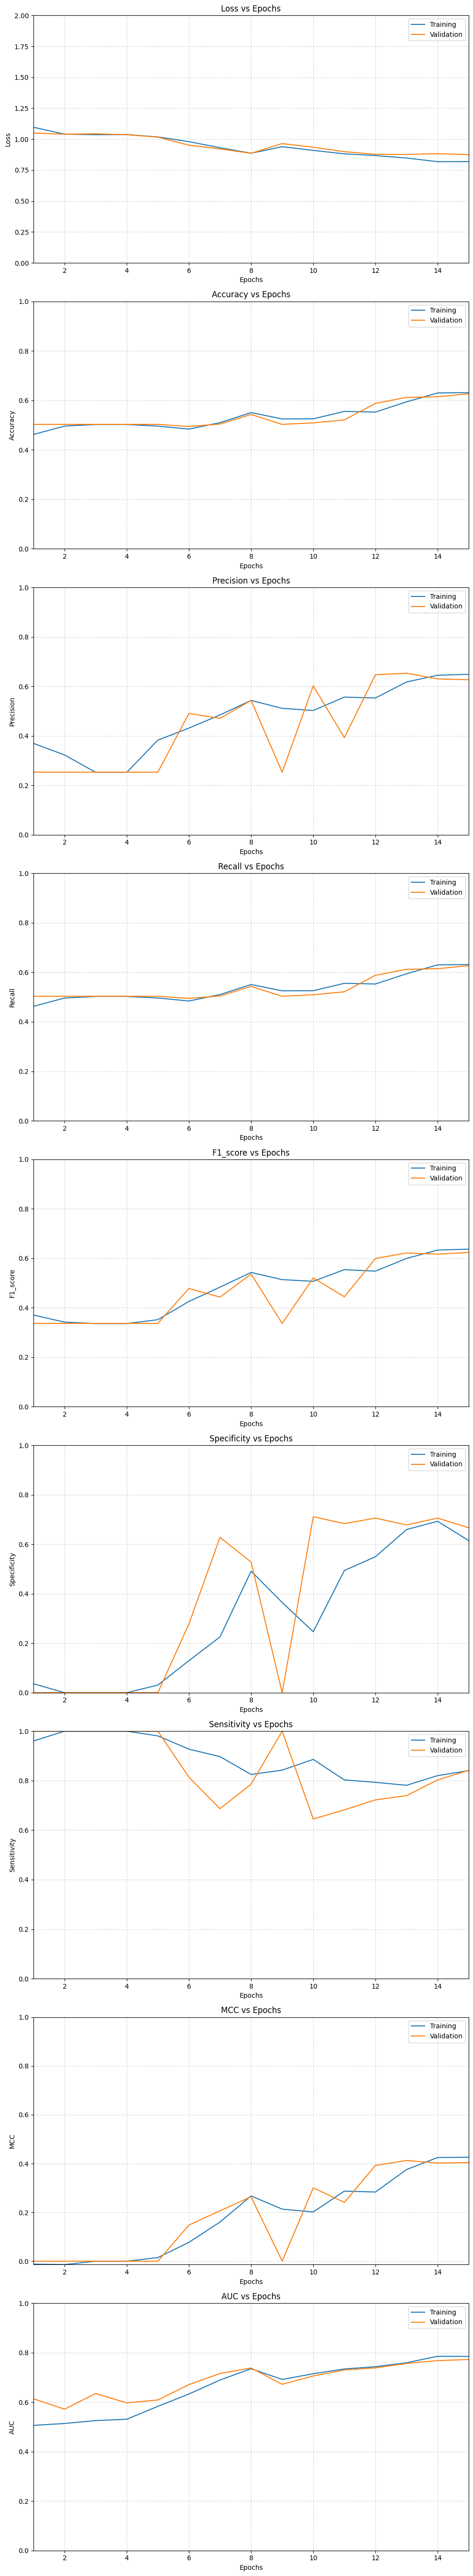

In [74]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)